# Assignment 2
In which we rewrite the PCA algorithm to transform a dataset.

Notes on PCA:
- Useful for reducing dimensionality for visualization, exploration, prediction.
- Drawback: the resulting features (basis) are linear combinations of multiple variables, so less interpretable.

In [3]:
from __future__ import division
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Part 1
Implement PCA following [this tutorial](https://plot.ly/ipython-notebooks/principal-component-analysis/) and test on sample iris data.

High-level order of operations:
- Standardize data X.
- Compute eigenvectors, eigenvalues from covariance or correlation matrix OR perform Singular Vector Decomposition.
- Select k eigenvectors with k-largest eigenvalues.
- Build projection matrix W from eigenvectors.
- Transform X with W to obtain k-dimensional subspace Y.

In [17]:
df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
)
df.columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how='all', inplace=True)
print(df.head())
X = df.iloc[:,0:4]
y = df.iloc[:,4]

   sepal_len  sepal_wid  petal_len  petal_wid        class
0        5.1        3.5        1.4        0.2  Iris-setosa
1        4.9        3.0        1.4        0.2  Iris-setosa
2        4.7        3.2        1.3        0.2  Iris-setosa
3        4.6        3.1        1.5        0.2  Iris-setosa
4        5.0        3.6        1.4        0.2  Iris-setosa


Plot distibutions!

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


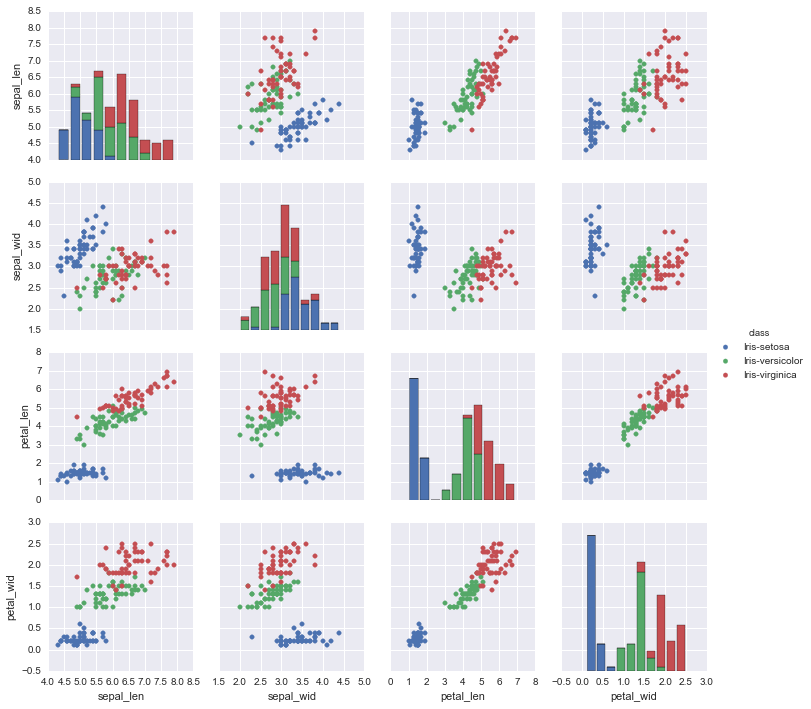

In [8]:
import seaborn as sns
sns.pairplot(df, hue='class')
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [22]:
N = X_std.shape[0]
X_mean = pd.np.mean(X_std, axis=0)
X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (N-1)
# X_cov = pd.np.cov(X_std.T)
print('covariance:\n%s'%(X_cov))

covariance:
           sepal_len  sepal_wid  petal_len  petal_wid
sepal_len   1.006711  -0.110103   0.877605   0.823443
sepal_wid  -0.110103   1.006711  -0.423338  -0.358937
petal_len   0.877605  -0.423338   1.006711   0.969219
petal_wid   0.823443  -0.358937   0.969219   1.006711


In [23]:
eig_vals, eig_vectors = pd.np.linalg.eig(X_cov)
print('eigenvalues:\n%s'%(eig_vals))
print('eigenvectors:\n%s'%(eig_vectors))

eigenvalues:
[ 2.93035378  0.92740362  0.14834223  0.02074601]
eigenvectors:
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


Cool! Let's confirm that SVD produces same eigenvectors.

In [24]:
u, s, v = pd.np.linalg.svd(X_std.T)
print(u)

[[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


In [25]:
for eig_vector in eig_vectors:
    pd.np.testing.assert_array_almost_equal(1., pd.np.linalg.norm(eig_vector))
print('Everything good')

Everything good


Compare variance explained among top-k eigenvectors.

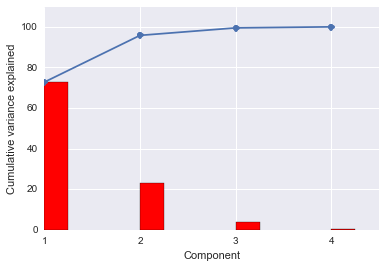

In [37]:
tot = sum(eig_vals)
var_exp = [(eig_val / tot)*100 for eig_val in sorted(eig_vals, reverse=True)]
cum_var_exp = pd.np.cumsum(var_exp)
x_positions = pd.np.arange(len(eig_vals)) + 1
plt.bar(x_positions, var_exp, color='r', width=.25)
plt.plot(x_positions, cum_var_exp, '-o')
plt.xticks(x_positions, x_positions)
plt.xlabel('Component')
plt.ylabel('Cumulative variance explained')
plt.ylim(0, 110)
plt.show()

First two components explain > 90% of variance.

Let's extract the first two components!

In [73]:
# eig_pairs = [(abs(eig_vals[i]), eig_vectors[i]) for i in range(len(eig_vals))] 
eig_pairs = [(pd.np.abs(eig_vals[i]), eig_vectors[:,i]) for i in range(len(eig_vals))]
print(eig_pairs)
W = pd.np.hstack((eig_pairs[0][1].reshape(4,1),
                  eig_pairs[1][1].reshape(4,1)))
k = 2
d = 4
W = pd.np.hstack((eig_pairs[i][1].reshape(d, 1) for i in range(k)))
print(W)

[(2.9303537755893174, array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105])), (0.92740362151734212, array([-0.37231836, -0.92555649, -0.02109478, -0.06541577])), (0.14834222648163983, array([-0.72101681,  0.24203288,  0.14089226,  0.6338014 ])), (0.020746013995595908, array([ 0.26199559, -0.12413481, -0.80115427,  0.52354627]))]
[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


Project onto new feature space and visualize different classes across first $k$ principal components.

In [66]:
Y = X_std.dot(W)
Y.columns = [str(i) for i in range(Y.shape[1])]

In [67]:
print(Y.head())

          0         1
0 -2.264542 -0.505704
1 -2.086426  0.655405
2 -2.367950  0.318477
3 -2.304197  0.575368
4 -2.388777 -0.674767


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


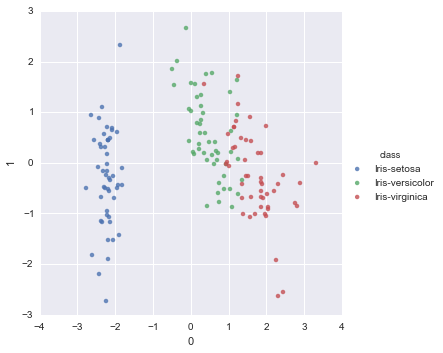

In [70]:
Y.loc[:, 'class'] = df.loc[:, 'class']
sns.lmplot(x='0', y='1', data=Y, hue='class', fit_reg=False)
plt.show()

The classes are well-separated! `iris-setosa` is now occupying its own subspace while `iris-versicolor` and `iris-virginica` are closer together but still reasonably separated.

## Part 2

Write-up paragraph:

I chose a dataset on the vocal quality of a population of Parkinson's patients and a control population of healthy patients ($N=197$) with 22 separate voice measurement features. I chose to reduce the data to 3 principal components that explained a cumulative 99.8% of the variance in the predicted variable (Parkinson's versus healthy). I chose $k=3$ first for the high cumulative sum of variance explained and second for the grouping of features into roughly 3 categories: (1) fundamental frequency variation , (2) amplitude variation ("shimmer"), and (3) nonlinear and complex metrics. Computing the correlations between the principal components and the original features revealed that the first component encodes more interpretable features such as maximum fundamental frequency, the second component encodes more complex features such as frequency variation, and the third component accounts for some complex relationships between variables. Although I am not involved with medicine, I would be curious to further investigate the data by comparing the distributions of the fundamental frequency variables (correlated with the first component) across Parkinson's versus healthy patients and look for combinations of the fundamental frequency variables that have high correlation. This would help determine whether some of the features are redundant, and could help future research reduce the feature space to a manageable space.

Perform PCA on sample dataset from here: https://archive.ics.uci.edu/ml/datasets.html 

Let's use this one about Parkinson's ($N=197, F=23$): https://archive.ics.uci.edu/ml/datasets/Parkinsons

Goal: differentiate healthy from afflicted patients.

In [10]:
df = pd.read_csv('data/parkinsons.csv')
print(sorted(df.columns))
print(df.head())

['D2', 'DFA', 'HNR', 'Jitter:DDP', 'MDVP:APQ', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'MDVP:RAP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'NHR', 'PPE', 'RPDE', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA', 'name', 'spread1', 'spread2', 'status']
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer    ...     \
0           0.00007   0.00370   0.00554     0.01109       0.04374    ...      
1           0.00008   0.00465   0.00696     0.01394       0.06134    ...

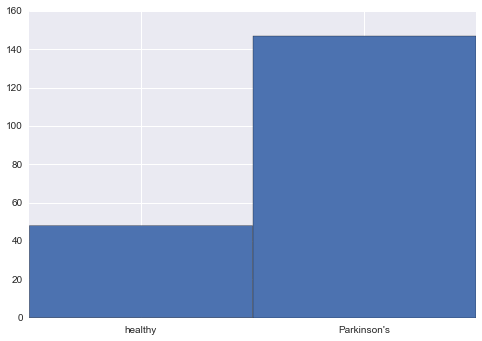

In [11]:
y_name = 'status'
plt.hist(df.loc[:, y_name], bins=2)
plt.xticks([0.25,0.75], ['healthy', 'Parkinson\'s'])
plt.show()

Base case: let's try PCA with $k=2$.

In [15]:
from sklearn.decomposition import PCA
x_names = sorted(set(df.columns) - set([y_name, 'name']))
print(x_names)

['D2', 'DFA', 'HNR', 'Jitter:DDP', 'MDVP:APQ', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'MDVP:RAP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'NHR', 'PPE', 'RPDE', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA', 'spread1', 'spread2']


In [20]:
X = df.loc[:, x_names]
Y = df.loc[:, y_name]
k = 2
pca = PCA(n_components=k)
pca.fit(X)
X_transform = pd.DataFrame(pca.transform(X))
X_transform.columns = ['%d'%(i) for i in range(k)]
print(X_transform.head())

           0          1
0 -49.702790  44.495243
1 -54.357102  11.019336
2 -72.854413  12.597009
3 -66.304920  14.114768
4 -62.712834  15.868356


Plot data and group by status.

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


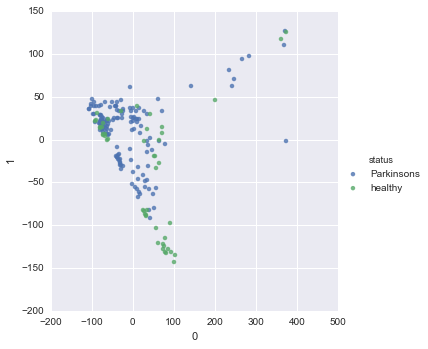

In [24]:
X_transform.loc[:, 'status'] = ['healthy' if y==0 else 'Parkinsons' for y in Y]
sns.lmplot(data=X_transform, x='0', y='1', hue='status', fit_reg=False)
plt.show()

Not a very good separation! Some of the healthy patients are mixed in with the Parkinsons patients, although there is some separation in the midrange of component 0 and lower range of component 1.

Let's investigate the amount of variance explained by the components for $k=5$, which is still much smaller than the total number of attributes $F=22$.

In [26]:
k = 5
pca = PCA(n_components=k)
pca.fit(X)
X_transform = pd.DataFrame(pca.transform(X))
var_explained = pca.explained_variance_
print(var_explained)
var_explained_cumsum = pca.explained_variance_ratio_.cumsum()
print(var_explained_cumsum)

[  8.70228753e+03   2.60527633e+03   6.10251155e+02   1.90252636e+01
   4.77398715e-01]
[ 0.72899269  0.9472373   0.99835818  0.99995193  0.99999193]


Interesting! It looks like 3 components are all we need to get to 99.8% of variance explained. So we should probably stick with $k=3$.

Let's find out how the top $k=3$ components co-vary with the original features.

In [37]:
from scipy.stats import pearsonr
k = 3
pca = PCA(n_components=k)
pca.fit(X)
X_transform = pd.DataFrame(pca.transform(X))
# feature_component_correls = pd.np.dot(X.T, X_transform)
F = X.shape[1]
feature_component_correls = pd.np.zeros((F, k))
for j in range(k):
    for f in range(F):
        feature_component_correls[f, j] = pearsonr(X.iloc[:, f], X_transform.iloc[:, j])[0]
feature_component_correls = pd.DataFrame(feature_component_correls, index=X.columns)
print(feature_component_correls)

                         0         1         2
D2                0.181204  0.046473 -0.261374
DFA              -0.371884  0.122639  0.365351
HNR              -0.009722 -0.178848  0.145135
Jitter:DDP        0.080955  0.139292  0.031425
MDVP:APQ         -0.007090  0.111425 -0.016901
MDVP:Fhi(Hz)      0.993041  0.112798  0.033851
MDVP:Flo(Hz)      0.177975 -0.919162  0.351366
MDVP:Fo(Hz)       0.502462 -0.729264 -0.464441
MDVP:Jitter(%)    0.080013  0.187242  0.045104
MDVP:Jitter(Abs) -0.076046  0.357457  0.177658
MDVP:PPQ          0.071871  0.151202  0.080296
MDVP:RAP          0.080981  0.139314  0.031378
MDVP:Shimmer     -0.013075  0.145103 -0.031985
MDVP:Shimmer(dB)  0.029467  0.131268 -0.017258
NHR               0.149284  0.142847 -0.017009
PPE              -0.115836  0.379780  0.078784
RPDE             -0.160014  0.409568  0.009174
Shimmer:APQ3     -0.018679  0.145290 -0.046207
Shimmer:APQ5     -0.020344  0.098548 -0.026336
Shimmer:DDA      -0.018670  0.145295 -0.046173
spread1      

Insights based on high absolute correlation coefficient values:

- First component encodes basic fundamental frequency features, including `MVDP:Fhi` (maximum fundamental frequency) and `MVDP:Fo` (average fundamental frequency).
- Second component encodes more complex features including nonlinear frequency variation (e.g., `spread1`, `PPE`), variation in fundamental frequency (`MDVP:Jitter`), and nonlinear complexity (`RPDE`).
- Third component encodes some unexpected relationships, such as inverse proportionality between `MDVP:Flo` (minimum fundamental frequency) and `MDVP:Fo` (positive correlation versus negative correlation).